In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_management import load_tsv
from data_utils import string_encoding_to_datetime, select_by_dict, get_df_with_split_time, print_unique_values
plt.rcParams['figure.figsize'] = 20, 16

## Nights spent data

read the data

In [3]:
# Nights spent at tourist accommodation establishments - monthly data
nights_spent = load_tsv("tour_occ_nim.tsv", decode=True)
print_unique_values(nights_spent)

c_resid
	Foreign country
	Reporting country
	Total
unit
	Number
	Percentage change compared to same period in previous year
nace_r2
	Hotels and similar accommodation
	Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Holiday and other short-stay accommodation
	Holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Camping grounds, recreational vehicle parks and trailer parks
geo
	Albania
	Austria
	Belgium
	Bulgaria
	Switzerland
	Cyprus
	Czechia
	Germany (until 1990 former territory of the FRG)
	Denmark
	Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
	Estonia
	Greece
	Spain
	European Union - 27 countries (2007-2013)
	European Union - 28 countries
	Finland
	France
	Croatia
	Hungary
	Ireland
	Iceland
	Italy
	Liechtenstein
	Lithuania
	Luxembourg
	Latvia
	Montenegro
	North Macedonia
	Malta
	Netherlands
	Norway
	Poland
	Portugal
	

In [4]:
# clean the data
nights = select_by_dict(nights_spent, {
    "c_resid": "Foreign country",
    "unit": "Number",
    "nace_r2": "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks"
})

# correct time
nights["time"] = nights["time"].apply(string_encoding_to_datetime)

# drop total EU values
nights = nights[(nights.geo!='Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)')&
      (nights.geo!='European Union - 28 countries')&
      (nights.geo!='European Union - 27 countries (2007-2013)')]

### Top 5 countries with most nights spent by tourists (average per year)

In [5]:
nights.groupby('geo')['value'].mean().sort_values( ascending=False).head(5)

geo
Spain             1.636891e+07
France            1.242120e+07
Italy             1.232398e+07
United Kingdom    9.202080e+06
Austria           6.041913e+06
Name: value, dtype: float64

### Bottom 5 countries by nights spent by tourists (average per year)

In [6]:
nights.groupby('geo')['value'].mean().sort_values().head(5)

geo
Liechtenstein                                                         12544.049751
Kosovo (under United Nations Security Council Resolution 1244/99)     18722.968750
North Macedonia                                                       80478.632479
Latvia                                                               197286.975124
Luxembourg                                                           198214.270423
Name: value, dtype: float64

### Time series of top 5 countries

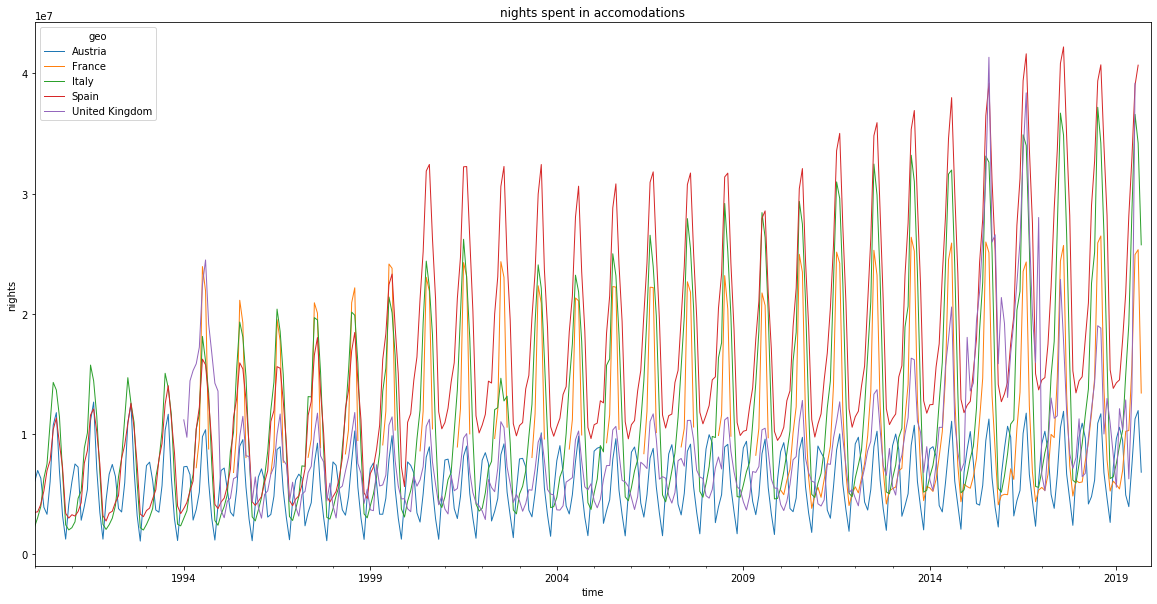

In [7]:
top = ['Spain', 'France', 'Italy', 'United Kingdom', 'Austria']
top_series = nights[(nights['geo'].isin(top))]#.dropna()

import datetime
#[top_series.time>datetime.date(2000, 1, 1)]
top_series.pivot(index='geo', columns='time', values='value').T.plot(figsize=(20,10), linewidth=1)
# we can plot this seperately for each country
plt.title('nights spent in accomodations')
plt.ylabel('nights')
plt.savefig('plots/top_5_nights.png', bbox_inches='tight')

### we can see an overal increase trend in the nights spent for Spain, Italy and somewhat UK.  

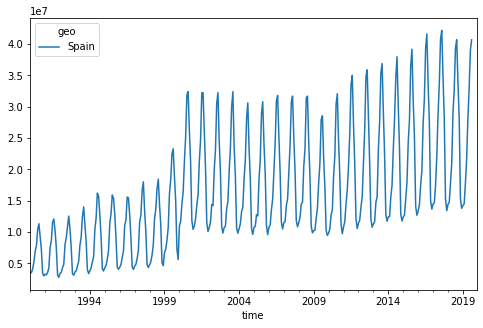

In [8]:
top_series[top_series.geo=='Spain'].pivot(index='geo', columns='time', values='value').T.plot(figsize=(8,5))

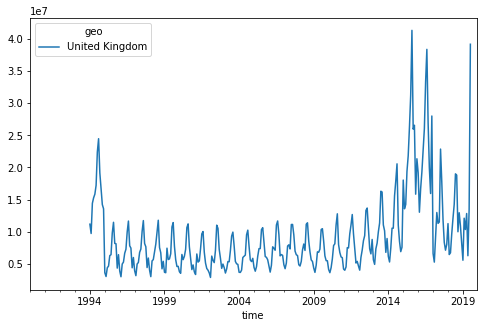

In [9]:
top_series[top_series.geo=='United Kingdom'].pivot(index='geo', columns='time', values='value').T.plot(figsize=(8,5))

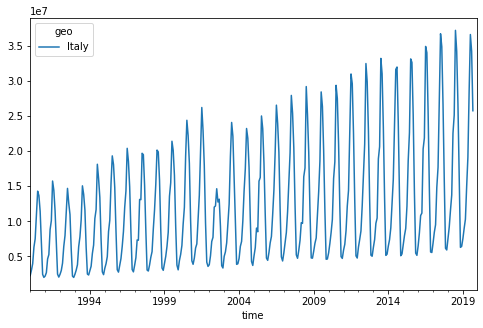

In [10]:
top_series[top_series.geo=='Italy'].pivot(index='geo', columns='time', values='value').T.plot(figsize=(8,5))

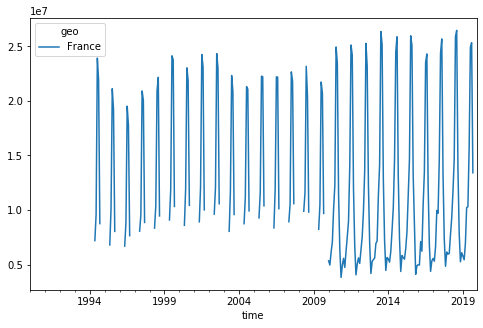

In [11]:
top_series[top_series.geo=='France'].pivot(index='geo', columns='time', values='value').T.plot(figsize=(8,5))

### Looking at seasonality trends

lets look at the seasonality of mean of nights spent

In [12]:
seasons = nights.copy()
# get the month
seasons['month'] = nights.time.dt.month
seasons['year'] = nights.time.dt.year

seasons = pd.pivot_table(seasons, index='month', columns = 'year', values = 'value', aggfunc=np.mean)

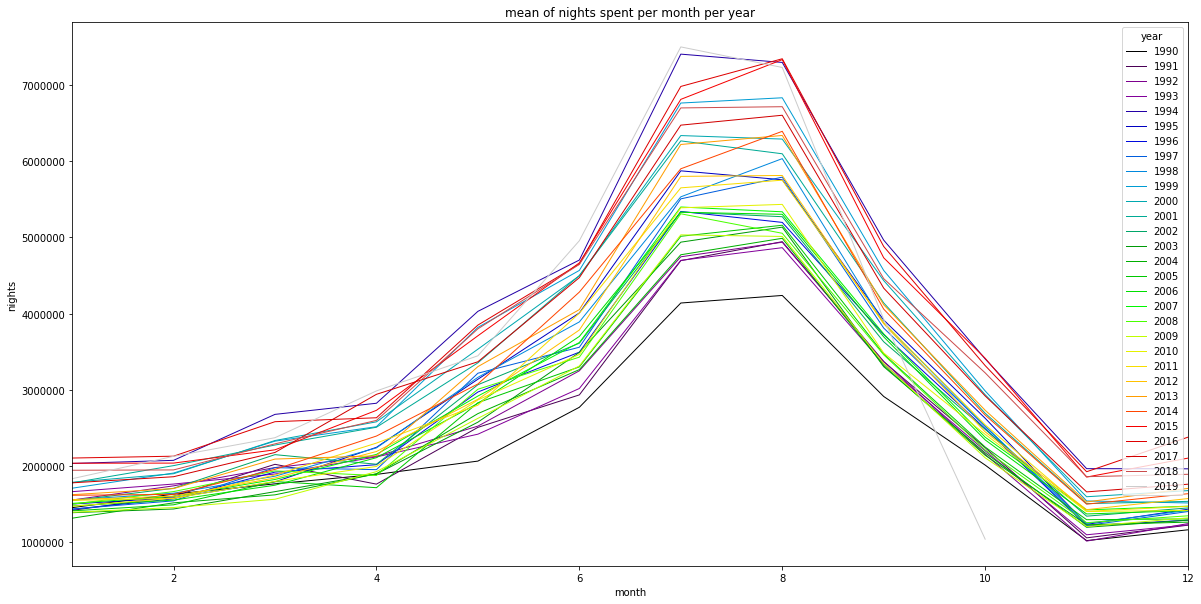

In [13]:
colors = plt.cm.nipy_spectral(np.linspace(0, 1, 30)) 
seasons.plot(figsize=(20,10), linewidth=1, color=colors)
# better to do a radar plot
plt.ylabel('nights')

plt.title('mean of nights spent per month per year');
plt.savefig('plots/seasonality_months_year.png', bbox_inches='tight')

Median of nigts spent seasonality

In [14]:
seasons = nights.copy()
# get the month
seasons['month'] = nights.time.dt.month
seasons['year'] = nights.time.dt.year

seasons = pd.pivot_table(seasons, index='month', columns = 'year', values = 'value', aggfunc=np.median)

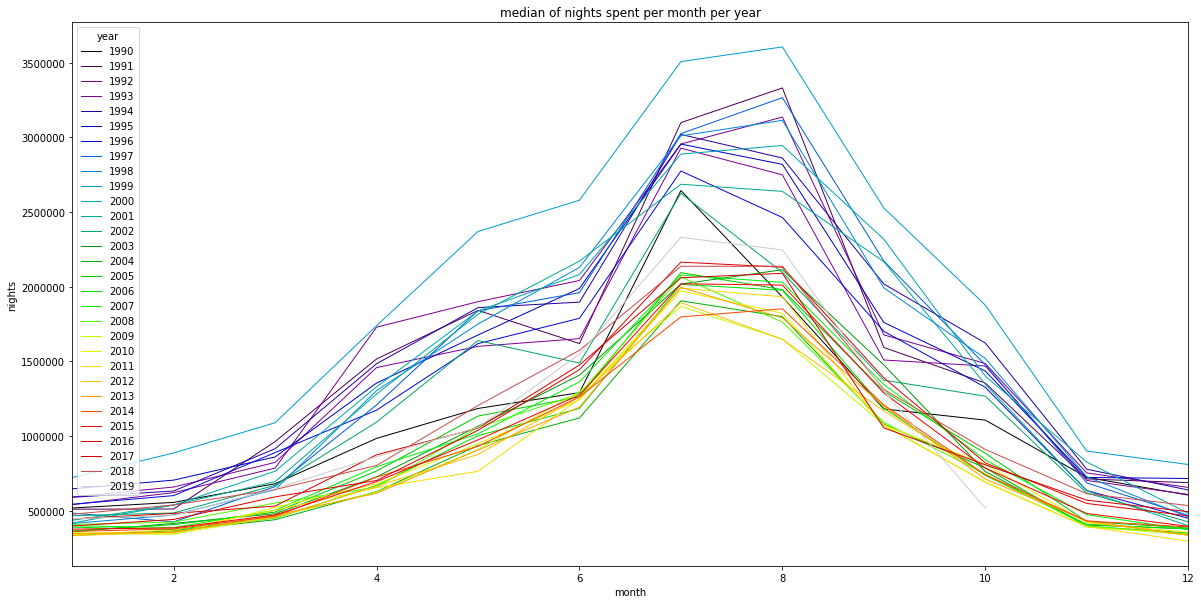

In [15]:
colors = plt.cm.nipy_spectral(np.linspace(0, 1, 30)) 
seasons.plot(figsize=(20,10), linewidth=1, color=colors)
# better to do a radar plot
plt.title('median of nights spent per month per year');
plt.ylabel('nights')
plt.savefig('plots/median_month_year.png', bbox_inches='tight')

we can see a nice dependence of nights spent on the month/season. Also we see that there is a peak during july(7) and august(8) beacuse of summer. 
we can also see a small increase on december(12) chrismas holidays.

we also see that the from past to present the mean increases.

if we plot the median we get a reverse relation. The meadian of past years are higher than the median of recent years. This might be because in recent years some specific countries get a lot of visitors while the other countries loose their tourists. which increases the mean but lowers the median.

lets also look at seasonality in the level of countries instead of years.
we normalize the countries to make them comparable.

In [16]:
nights.head()

,geo,time,value
41,Albania,2019-12-01,NaN
42,Austria,2019-12-01,NaN
43,Belgium,2019-12-01,NaN
44,Bulgaria,2019-12-01,NaN
45,Switzerland,2019-12-01,NaN


In [17]:
nights_seasons = nights.copy()
# get the month
nights_seasons['month'] = nights.time.dt.month
nights_seasons['year'] = nights.time.dt.year

nights_seasons = pd.pivot_table(nights_seasons, index='month', columns = 'geo', values = 'value', aggfunc=np.mean)
# normalize by total of the country itself
nights_seasons = nights_seasons.div(nights_seasons.sum(axis=0), axis=1)

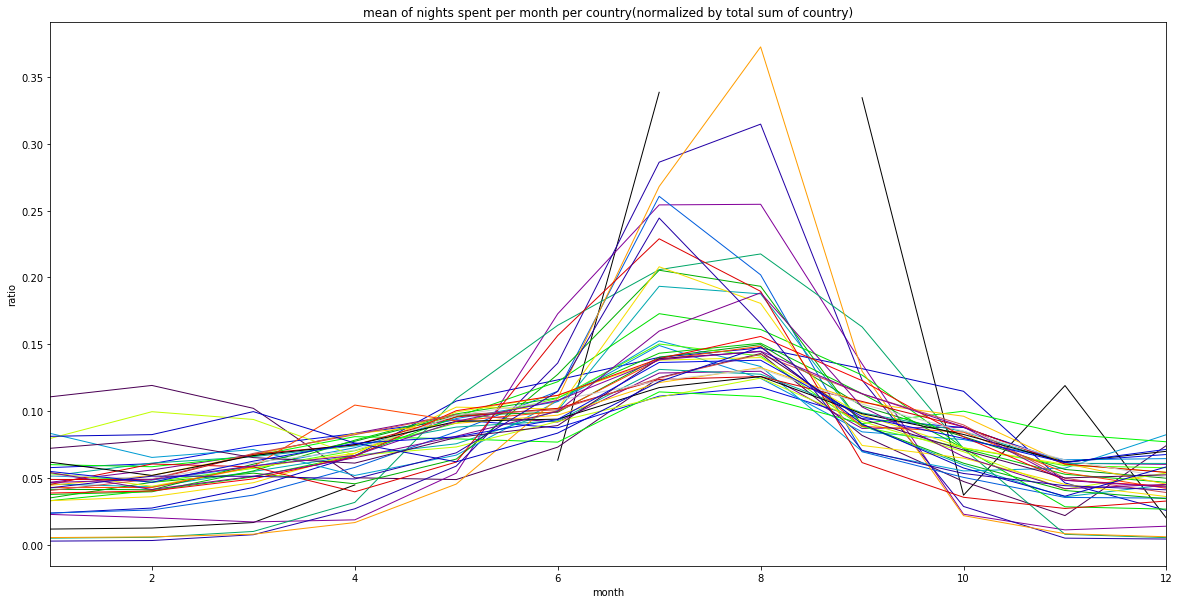

In [18]:
colors = plt.cm.nipy_spectral(np.linspace(0, 1, 30)) 
nights_seasons.plot(figsize=(20,10), linewidth=1, color=colors, legend=None)
# better to do a radar plot
plt.title('mean of nights spent per month per country(normalized by total sum of country)');
plt.ylabel('ratio')
plt.savefig('plots/country_ratio_means_month.png', bbox_inches='tight')

so we also see seasonality in the level of countries.
let's see which countries have the more dependence on seasonality by looking at the std of their values through seasons.

## map the values

In [19]:
nights_seasons.std().sort_values(ascending=False).head(10)

geo
Albania       0.128640
Montenegro    0.120271
Croatia       0.111375
Bulgaria      0.095244
Greece        0.084473
Denmark       0.074985
Norway        0.068188
Sweden        0.062549
Iceland       0.060248
Luxembourg    0.057271
dtype: float64

we can also measure seasonality by amount of increase from month 6 to 8.

In [20]:
(nights_seasons.loc[8] - nights_seasons.loc[6]).sort_values(ascending=False).head(10)

geo
Montenegro     0.262496
Croatia        0.178448
Slovenia       0.088523
France         0.087078
Denmark        0.086974
Bulgaria       0.081811
Luxembourg     0.078880
Austria        0.069888
Iceland        0.065788
Switzerland    0.064269
dtype: float64

## Employment data

read the data

In [191]:
### Looking at the employment data
# read  and clean
orig_employ = pd.read_csv('data_store/tour_lfsq4r2.tsv', sep='\t')


def clean(data):
    # remove white spaces
    data.columns = data.columns.str.strip() # remove space from column name
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # remove flags from numeric columns
    data.iloc[:,1:] = data.iloc[:,1:].applymap(lambda x: x.strip('bepucfrzdns').strip() if isinstance(x, str) else x)

    # replace ':' with NAN
    data.replace(':', np.NaN, inplace=True)

    # cast columns to number (it will be float since we also have percentages)
    data.iloc[:,1:] = data.iloc[:,1:].applymap(lambda x: pd.to_numeric(x))
    
    return data

orig_employ = clean(orig_employ).infer_objects()

In [192]:
def correct_specs_column1(data):
    # turn the first column into different columns 'specs'
    specs = data.iloc[:,0].str.split(',', expand=True)
    specs.columns = ['nace_r2','emp_cont','unit','geo_time']
    # now join with the numeric data
    age_number = pd.concat([specs, data.iloc[:,1:]], axis=1)
    return age_number

In [193]:
employ_number = correct_specs_column1(orig_employ)

In [194]:
employ_number.head()

,nace_r2,emp_cont,unit,geo_time,2019Q3,2019Q2,2019Q1,2018Q4,2018Q3,2018Q2,...,2010Q2,2010Q1,2009Q4,2009Q3,2009Q2,2009Q1,2008Q4,2008Q3,2008Q2,2008Q1
0,H51,LTD,THS,AT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H51,LTD,THS,BE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H51,LTD,THS,BG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H51,LTD,THS,CH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H51,LTD,THS,CY,NaN,NaN,NaN,NaN,NaN,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
def Country_Codes_to_names(data):
    # turn country codes into names
    country_info = pd.read_excel('data_store/country_info.xls')
    country_info = country_info.set_index('CODE')
    country_info = country_info.iloc[:,0:1]
    # turn the dataframe into dictionary
    di = country_info.to_dict()['LIBEN']
    
    # turn code into name for origin
    data['geo_time'] = data['geo_time'].map(di).fillna(data['geo_time'])
    
    # for destination
    #data['partner'] = data['partner'].map(di).fillna(data['partner'])
    
    return data

In [196]:
# look how perm jobs change in months vs non-perms
# calculate correlation with #nights

In [197]:
employ_number = Country_Codes_to_names(employ_number)

In [198]:
employ_number.head()

,nace_r2,emp_cont,unit,geo_time,2019Q3,2019Q2,2019Q1,2018Q4,2018Q3,2018Q2,...,2010Q2,2010Q1,2009Q4,2009Q3,2009Q2,2009Q1,2008Q4,2008Q3,2008Q2,2008Q1
0,H51,LTD,THS,Austria,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H51,LTD,THS,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H51,LTD,THS,Bulgaria,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H51,LTD,THS,Switzerland,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H51,LTD,THS,Cyprus,NaN,NaN,NaN,NaN,NaN,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
employ_number.groupby(['nace_r2', 'emp_cont', 'unit']).count()

geo_time  2019Q3  2019Q2  2019Q1  2018Q4  2018Q3  \
nace_r2 emp_cont unit                                                     
H51     LTD      THS         38       2       5       5       6       6   
        NLTD     THS         38      10      29      26      29      28   
        TOTAL    THS         38      10      29      28      30      30   
        UNK      THS         13       0       0       0       0       0   
I       LTD      THS         38      11      32      32      32      33   
        NLTD     THS         38      12      38      38      38      38   
        TOTAL    THS         38      12      38      38      38      38   
        UNK      THS         18       1       1       3       4       4   
I55     LTD      THS         38      11      28      25      25      27   
        NLTD     THS         38      12      37      36      38      37   
        TOTAL    THS         38      12      37      37      38      38   
        UNK      THS         17       0       0       0       0       1   
N79     LTD      THS         38       4       9       7       7      12   
        NLTD     THS         38      11      28      28      26      27   
        TOTAL    THS         38      11      29      28      28      29   
        UNK      THS         14       0       0       0       0       0   
TOTAL   LTD      THS         38      12      38      38      38      38   
        NLTD     THS         38      12      38      38      38      38   
        TOTAL    THS         38      12      38      38      38      38   
        UNK      THS         21       5      12      13      12      13   

                       2018Q2  2018Q1  2017Q4  2017Q3  ...  2010Q2  2010Q1  \
nace_r2 emp_cont unit                                  ...                   
H51     LTD      THS        6       5       7       7  ...       4       6   
        NLTD     THS       27      26      28      24  ...      28      27   
        TOTAL    THS       28      26      28      26  ...      29      27   
        UNK      THS        0       0       0       0  ...       0       0   
I       LTD      THS       33      31      31      33  ...      30      28   
        NLTD     THS       38      38      38      38  ...      36      35   
        TOTAL    THS       38      38      38      38  ...      36      35   
        UNK      THS        3       3       3       5  ...       2       2   
I55     LTD      THS       26      24      25      29  ...      26      23   
        NLTD     THS       37      37      35      36  ...      33      32   
        TOTAL    THS       38      37      35      37  ...      33      32   
        UNK      THS        0       0       0       0  ...       0       1   
N79     LTD      THS       11       7       7       9  ...      11       8   
        NLTD     THS       28      24      27      26  ...      26      27   
        TOTAL    THS       30      27      28      31  ...      27      27   
        UNK      THS        0       0       0       0  ...       0       0   
TOTAL   LTD      THS       38      38      38      38  ...      37      36   
        NLTD     THS       38      38      38      38  ...      37      36   
        TOTAL    THS       38      38      38      38  ...      37      36   
        UNK      THS       12      13      12      13  ...      11      11   

                       2009Q4  2009Q3  2009Q2  2009Q1  2008Q4  2008Q3  2008Q2  \
nace_r2 emp_cont unit                                                           
H51     LTD      THS        4       5       5       6       7       6       6   
        NLTD     THS       25      26      27      25      25      25      27   
        TOTAL    THS       25      26      28      25      25      26      28   
        UNK      THS        0       0       0       0       0       0       0   
I       LTD      THS       28      30      29      27      26      29      28   
        NLTD     THS       34      34      35      34      33      33      34   
       

In [200]:
# select sections we want (cleaning)

# drop total EU values
def drop_EU(data):
    
    return data[(data.index!='EA19')&
                (data.index!='EU15')&
                (data.index!='EU28')]

# umlimited (premanent employment)
perm_employ = employ_number[(employ_number.nace_r2=='TOTAL')&
             (employ_number.emp_cont=='NLTD') & (employ_number.unit=='THS')]
# drop spec columns
perm_employ = perm_employ.drop(labels=['nace_r2', 'emp_cont', 'unit'], axis =1).set_index('geo_time')
perm_employ = drop_EU(perm_employ)

# limited (temporary employment)
temporary_employ = employ_number[(employ_number.nace_r2=='TOTAL')&
             (employ_number.emp_cont=='LTD') & (employ_number.unit=='THS')]
# drop spec columns
temporary_employ = temporary_employ.drop(labels=['nace_r2', 'emp_cont', 'unit'], axis =1).set_index('geo_time')
temporary_employ = drop_EU(temporary_employ)

### lets see top 5 countries with most premanent employment

In [201]:
perm_employ.mean(axis=1).sort_values(ascending=False).head(5)

geo_time
Germany           30608.069565
United Kingdom    24392.342553
France            19588.621277
Italy             14748.878261
Turkey            14312.769565
dtype: float64

### Top 5 countries with most temporary employment

In [202]:
temporary_employ.mean(axis=1).sort_values(ascending=False).head(5)

geo_time
Germany    4787.632609
Spain      3934.876596
France     3647.302128
Poland     3327.517391
Italy      2405.606522
dtype: float64

### we will focus on temporary jobs and calculate their correlation with nights spent by tourists.(a measure of popularity of the country in tourism)

### seasonality of temporary employment

In [203]:
temporary_employ.columns

Index(['2019Q3', '2019Q2', '2019Q1', '2018Q4', '2018Q3', '2018Q2', '2018Q1',
       '2017Q4', '2017Q3', '2017Q2', '2017Q1', '2016Q4', '2016Q3', '2016Q2',
       '2016Q1', '2015Q4', '2015Q3', '2015Q2', '2015Q1', '2014Q4', '2014Q3',
       '2014Q2', '2014Q1', '2013Q4', '2013Q3', '2013Q2', '2013Q1', '2012Q4',
       '2012Q3', '2012Q2', '2012Q1', '2011Q4', '2011Q3', '2011Q2', '2011Q1',
       '2010Q4', '2010Q3', '2010Q2', '2010Q1', '2009Q4', '2009Q3', '2009Q2',
       '2009Q1', '2008Q4', '2008Q3', '2008Q2', '2008Q1'],
      dtype='object')

In [204]:
temporary_employ.columns = temporary_employ.columns.to_series().apply(string_encoding_to_datetime)

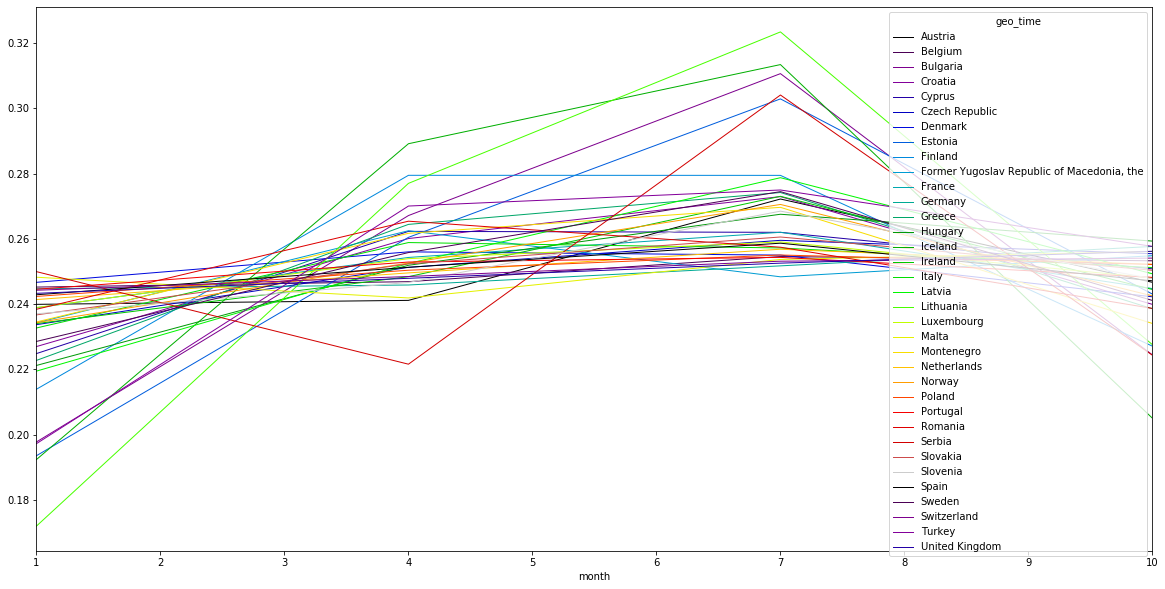

In [282]:
# unpivot
country_temp_employ = pd.melt(temporary_employ.reset_index(), id_vars=['geo_time'], 
                              value_vars=temporary_employ.columns,var_name='time', value_name='value')

# pivot
temp_employ_seasons = country_temp_employ.copy()
# get the month
temp_employ_seasons['month'] = temp_employ_seasons.time.dt.month
temp_employ_seasons['year'] = temp_employ_seasons.time.dt.year

temp_employ_seasons = pd.pivot_table(temp_employ_seasons, index='month', columns = 'geo_time', values = 'value', aggfunc=np.mean)
# normalize by total of the country itself
temp_employ_seasons = temp_employ_seasons.div(temp_employ_seasons.sum(axis=0), axis=1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 30)) 
temp_employ_seasons.plot(figsize=(20,10), linewidth=1, color=colors)

### we can see that the temporary employment data is also seasonal.

we will look at the nights spent also in the form of quarterly data to make them comparable to employment data.

In [247]:
quarter = pd.DataFrame(columns=nights_seasons.columns)
quarter.loc['1'] = nights_seasons.iloc[0:3,:].sum()
quarter.loc['4'] = nights_seasons.iloc[3:6,:].sum()
quarter.loc['7'] = nights_seasons.iloc[6:9,:].sum()
quarter.loc['10'] = nights_seasons.iloc[9:12,:].sum()

In [248]:
quarter.drop('Albania', axis=1)

geo,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,...,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
1,0.332529,0.171005,0.061052,0.014513,0.094940,0.193087,0.087890,0.159183,0.220601,0.144510,...,0.166166,0.158906,0.163869,0.181177,0.216395,0.147375,0.155311,0.146035,0.263829,0.164944
4,0.172750,0.273231,0.245714,0.222490,0.297907,0.264859,0.258009,0.274754,0.227248,0.243512,...,0.273045,0.281248,0.276246,0.261870,0.231289,0.246778,0.267706,0.233445,0.222432,0.251049
7,0.350445,0.345894,0.644368,0.724084,0.419615,0.323972,0.532471,0.358583,0.356388,0.470747,...,0.357300,0.380570,0.360281,0.342007,0.378351,0.451874,0.396671,0.481018,0.360827,0.370823
10,0.144275,0.209871,0.048866,0.038913,0.187538,0.218082,0.121630,0.207480,0.195764,0.141232,...,0.203489,0.179275,0.199604,0.214946,0.173964,0.153973,0.180311,0.139502,0.152911,0.213184


In [283]:
temp_employ_seasons.T.index

Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland',
       'Former Yugoslav Republic of Macedonia, the', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom'],
      dtype='object', name='geo_time')

In [285]:
quarter.T.index.difference(temp_employ_seasons.T.index)

Index(['Albania',
       'Kosovo (under United Nations Security Council Resolution 1244/99)',
       'Liechtenstein'],
      dtype='object')

In [284]:
# correct country names
quarter.rename(columns={'Czechia':'Czech Republic','Germany (until 1990 former territory of the FRG)':'Germany',
                        'North Macedonia':'Former Yugoslav Republic of Macedonia, the' }, inplace=True)

#### Here we can see that for some countries there is correlation close to 1 between employment and nights spent by tourists.

In [286]:
for country in quarter.columns:
    print(country)
    if country in temp_employ_seasons.columns:
        print(temp_employ_seasons.reset_index()[country].corr(quarter.reset_index()[country]))

Albania
Austria
0.5045610413185309
Belgium
0.5765426132220378
Bulgaria
0.9412953823292859
Croatia
0.8962757441328163
Cyprus
0.874478983941279
Czech Republic
0.7526350644683635
Denmark
0.7443579262964576
Estonia
0.9726538741677927
Finland
0.6384010822105313
France
0.9202393486745463
Germany
0.14920887450562267
Greece
0.9445199539642741
Hungary
0.7550524608710627
Iceland
0.8752476808837616
Ireland
0.9571997294346399
Italy
0.6712215734393543
Kosovo (under United Nations Security Council Resolution 1244/99)
Latvia
0.9216561311472639
Liechtenstein
Lithuania
0.970570656148642
Luxembourg
0.9084414296334781
Malta
0.05872688538346722
Montenegro
0.8334280235912989
Netherlands
0.7722138959818715
Former Yugoslav Republic of Macedonia, the
0.35068781880866096
Norway
0.9241342921159076
Poland
0.7941021996175388
Portugal
0.9330346739233579
Romania
0.7848668980016369
Serbia
0.692807359079399
Slovakia
0.6556805634513889
Slovenia
0.9364648937630402
Spain
0.9855211366521792
Sweden
0.9254003558166324
Swit

## Ploting seasonality of countries

In [58]:
import json
import geopandas as gpd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

def clean_to_plot(data, unpivot=False):
    # get country out of index
    # correct some country names
    data = data.reset_index()
    data = data.replace({'Germany (until 1990 former territory of the FRG)': 'Germany', 
                     'Kosovo (under United Nations Security Council Resolution 1244/99)': 'Kosovo'})

    # if the data needs unpivoting do it
    if unpivot:
        # unpivot the data
        data = pd.melt(data, id_vars=['geo_time'], value_vars=['2018', '2017', '2016', '2015', '2014', '2013', '2012'])
        data = data.rename({'variable': 'year'}, axis=1)

    # read the geo data 
    shapefile = 'data_store/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'#Read shapefile using Geopandas
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]#Rename columns.
    gdf.columns = ['country', 'country_code', 'geometry']

    
    #lower case the country names for join
    gdf['country'] = gdf.country.str.lower()
    data['geo_time'] = data.geo_time.str.lower()
    # join the geo data and values
    country_values = gdf.join(data.set_index('geo_time'),on='country', how='right')
    

    
    # drop countries without coordinates
    country_values.dropna(subset=['geometry'], inplace = True)
    
    #Replace NaN values to string 'No data'.
    country_values.replace(np.nan, 'No data', inplace = True)
    
    return country_values

In [74]:
def plot_world_map(data, unpivot=False, Title='Title', year='2018'):
    # clean and prepare first
    country_values = clean_to_plot(data)
    
    # rename column 
    country_values.columns = ['country', 'country_code', 'geometry', 'value']
    
    # select a year
    #country_values = country_values[country_values.year==year]
    
    # convert to jason for bokeh
    country_values_json = json.loads(country_values.to_json())#Convert to String like object.
    json_data = json.dumps(country_values_json)

    # plot in bokeh
    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = json_data)
    #Define a sequential multi-hue color palette.
    palette = brewer['YlGnBu'][8]
    #Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]
    
    # determin the range of the number from the input data
    upper_lim = data.max().max()
    lower_lim = data.min().min()
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = lower_lim, high = upper_lim,  nan_color = '#d9d9d9')
    #Define custom tick labels for color bar.
    tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
    #Create color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                         border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
    #Create figure object.
    p = figure(title = Title, plot_height = 700 , plot_width = 600, toolbar_location = None, 
               y_range=(30, 75), x_range=( -15, 35) )
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :'value', 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    #Display figure inline in Jupyter Notebook.
    output_notebook()
    #Display figure.
    show(p)

    return 

In [75]:
# clean the data for plot
data = nights_seasons.std()
data.index.name = 'geo_time'

## Map of countries by the amount of seasonality

Map of seasonality of countries as measured by the std of nights spent throughout different months.
the values of each month is the average over many years.

In [76]:
plot_world_map(data, Title='Map of seasonality of countries as measured by the std')

Loading BokehJS ...

In [68]:
clean_to_plot(data).columns = ['country', 'country_code', 'geometry', 'value']